## 2 - Emojifier-V2 : Using LSTMs in Keras  😀😀😀😀😀😀

- Let's build an LSTM model that takes as input word sequences. This model will be able to take word ordering into account. Emojifier-V2 will continue to use pre-trained word-embeddings to represent words, but we feed them into an LSTM, whose job is to predict the most appropriate emoji.

- We'll use the same dataset from the earlier model.

In [1]:
# Loading our dependencies 
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Activation, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from emoji_utils import *

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 2.1 - Overview of the model

Here is the Emojifier-v2 we will implement:

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 1**: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>

### 2.2 Keras and mini-batching 

In this exercise, we want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.

The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. In this example, any sentences longer than 20 words would have to be truncated. One simple way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 


In [2]:
X_train, Y_train = read_csv_file('data/train_emoji.csv')
X_test, Y_test = read_csv_file('data/test_emoji.csv')

print("Number of training examples : ",X_train.shape[0])
print("Number of testing examples : ",X_test.shape[0])

Number of training examples :  132
Number of testing examples :  56


In [3]:
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.50d.txt')

print(" Number of words in Glove_data set : ", len(word_to_vec_map.keys()))
print(" Size of each GloVe vector         : ", len(word_to_vec_map['sorry']))

 Number of words in Glove_data set :  400000
 Size of each GloVe vector         :  50


In [4]:
# Here length of largest phrase will be the max length of any input sentence
largest_phrase = max(X_train, key=len)
max_len = len(largest_phrase.split())
print("Length of largest phrase   : ", max_len)
print("Largest phrase in the data : ", largest_phrase)

Length of largest phrase   :  10
Largest phrase in the data :  I am so impressed by your dedication to this project


### 2.3 - The Embedding layer

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, We will learn how to create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras, initialize it with the GloVe 50-dimensional vectors loaded earlier in the notebook. Because our training set is quite small, we will not update the word embeddings but will instead leave their values fixed. But in the code below, we'll see how Keras allows us to either train or leave fixed this layer.  

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center> **Figure **: Embedding layer. This example shows the propagation of two examples through the embedding layer. Both have been zero-padded to a length of `max_len=5`. The final dimension of the representation is  `(2,max_len,50)` because the word embeddings we are using are 50 dimensional. </center></caption>

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

The first step is to convert all your training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence. 

In [5]:
def sentences_to_indices(X, word_to_index, max_len):
    
    # Number of training examples
    m = X.shape[0]
    
    # This array stores indices of words in each sentence(if len(sentence) = 3, all the other elements will be zeros)
    X_indices = np.zeros((m, max_len))
    
    
    for i in range(m):   # loop over training examples
        
        sentence_words = list(map(lambda word : word.lower(), X[i].split()))
        j = 0
        # loop over words in sentence_words
        for word in sentence_words:
            X_indices[i, j] = word_to_index[word]  # set X_indices[i, j] to the index of the word
            j += 1
            
    return X_indices

In [6]:
X1 = np.array(['take my money', 'deep learning', 'apple or samsung'])
X1_indices = sentences_to_indices(X1, words_to_index, max_len = 5)

print("X1 =", X1)
print("X1_indices = ", X1_indices)

X1 = ['take my money' 'deep learning' 'apple or samsung']
X1_indices =  [[351935. 254258. 248489.      0.      0.]
 [119136. 219115.      0.      0.      0.]
 [ 57797. 270970. 317225.      0.      0.]]


 - Let's build the `Embedding()` layer in Keras, using pre-trained word vectors. After this layer is built, we will pass the output of `sentences_to_indices()` to it as an input, and the `Embedding()` layer will return the word embeddings for a sentence. 

In [7]:
print(" Input dim of Embedding layer : (m, maxlen)")
print("Output dim of Embedding layer : (m, maxlen, 50)")

 Input dim of Embedding layer : (m, maxlen)
Output dim of Embedding layer : (m, maxlen, 50)


In [8]:
def pretrained_embedding_layer(word_to_vec_map, words_to_index):
    
    vocab_len = len(words_to_index) + 1                        # adding 1 to fit Keras embedding (requirement)
    embedding_vec_dim = word_to_vec_map['sorry'].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    
    embed_matrix = np.zeros((vocab_len, embedding_vec_dim))
    
    
    # set each row of the embed_matrix to be the glove vector of index'th word in the vocabulary
    for word, index in words_to_index.items():
        embed_matrix[index, :] = word_to_vec_map[word]
    
    # Keras embedding layer with the correct output/input sizes, Make sure to set trainable=False.
    embedding_layer = Embedding(input_dim=vocab_len, output_dim=embedding_vec_dim, trainable=False)
    
    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None, ))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([embed_matrix])
    
    return embedding_layer 

In [9]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, words_to_index)
print("weights[0][1] = ", embedding_layer.get_weights()[0][1])

weights[0][1] =  [-0.58402   0.39031   0.65282  -0.3403    0.19493  -0.83489   0.11929
 -0.57291  -0.56844   0.72989  -0.56975   0.53436  -0.38034   0.22471
  0.98031  -0.2966    0.126     0.55222  -0.62737  -0.082242 -0.085359
  0.31515   0.96077   0.31986   0.87878  -1.5189   -1.7831    0.35639
  0.9674   -1.5497    2.335     0.8494   -1.2371    1.0623   -1.4267
 -0.49056   0.85465  -1.2878    0.60204  -0.35963   0.28586  -0.052162
 -0.50818  -0.63459   0.33889   0.28416  -0.2034   -1.2338    0.46715
  0.78858 ]


## 2.3 - Building the Emojifier-V2

Let's now build the Emojifier-V2 model. we will do so using the embedding layer you have built, and feed its output to an LSTM network.


- We'll implement `Emojify_V2()`, which builds a Keras graph of the architecture shown in Figure 1. The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. It should output a softmax probability vector of shape (`m`, `C = 5`). You may need `Input(shape = ..., dtype = '...')`, [LSTM()](https://keras.io/layers/recurrent/#lstm), [Dropout()](https://keras.io/layers/core/#dropout), [Dense()](https://keras.io/layers/core/#dense), and [Activation()](https://keras.io/activations/).

- The flag `return_sequences=True` returns the hidden state output for each input , if set `False` only the hidden state of the last time step is returned.(https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)

In [10]:
def Emojify_V2(input_shape, word_to_vec_map, words_to_index):
    
    # sentence_indices as the input of the graph, 
    # it should be of shape input_shape and dtype 'int32' (as it contains indices)
    sentence_indices = Input(input_shape, dtype='int32')
    
    
    # embedding_layer pretrained with GloVe 
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, words_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings of propagted indices
    embeddings = embedding_layer(sentence_indices)
    
    # setting (return_sequences=True) passes all of the layers outputs at each time step to the next layer
    X = LSTM(units=128, activation='tanh', kernel_initializer=glorot_uniform(seed=0), return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    
    # since we are using a many-to-one network -->set (return_sequences=Fasle) in the second layer
    X = LSTM(units=128, activation='tanh', kernel_initializer=glorot_uniform(seed=0), return_sequences=False)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(5, activation='softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [11]:
model = Emojify_V2((max_len, ), word_to_vec_map, words_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total para

- All sentences in the dataset are less than 10 words, we chose `max_len = 10`.  If we see our architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

- It's time to train our model. Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [13]:
#train data
X_train_indices = sentences_to_indices(X_train, words_to_index, max_len)
Y_train_oh = one_hot(Y_train, 5)

In [14]:
#val data
X_test_indices = sentences_to_indices(X_test, words_to_index, max_len)
Y_test_oh = one_hot(Y_test, 5)

In [15]:
history = model.fit(X_train_indices, Y_train_oh, epochs=55, batch_size=32, shuffle=True, validation_data=(X_test_indices, Y_test_oh))

Train on 132 samples, validate on 56 samples
Epoch 1/55
132/132 [==============================] - 3s 19ms/step - loss: 1.6120 - acc: 0.2045 - val_loss: 1.5569 - val_acc: 0.3036
Epoch 2/55
132/132 [==============================] - 0s 2ms/step - loss: 1.5307 - acc: 0.2955 - val_loss: 1.5151 - val_acc: 0.3571
Epoch 3/55
132/132 [==============================] - 0s 2ms/step - loss: 1.4890 - acc: 0.3258 - val_loss: 1.4774 - val_acc: 0.4286
Epoch 4/55
132/132 [==============================] - 0s 2ms/step - loss: 1.4443 - acc: 0.3561 - val_loss: 1.4260 - val_acc: 0.4107
Epoch 5/55
132/132 [==============================] - 0s 2ms/step - loss: 1.3271 - acc: 0.5530 - val_loss: 1.3380 - val_acc: 0.4821
Epoch 6/55
132/132 [==============================] - 0s 2ms/step - loss: 1.2414 - acc: 0.5455 - val_loss: 1.2505 - val_acc: 0.4286
Epoch 7/55
132/132 [==============================] - 0s 2ms/step - loss: 1.1340 - acc: 0.5530 - val_loss: 1.1528 - val_acc: 0.6071
Epoch 8/55
132/132 [==========

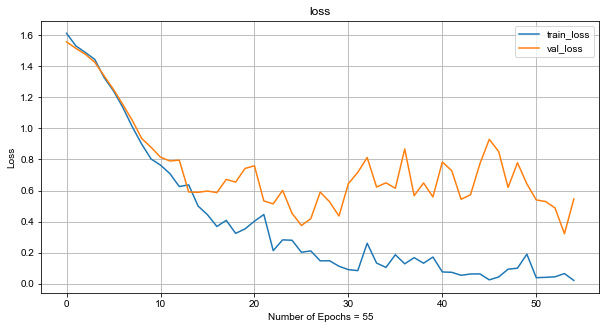

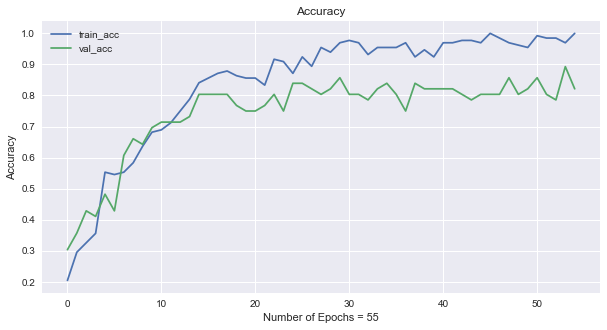

In [16]:
plot_history(history)

In [17]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
pred_test = model.predict(X_test_indices)
print("    test loss : %f"%(loss))
print("test accuracy : %f"%(acc))

56/56 [==============================] - 0s 291us/step
    test loss : 0.545590
test accuracy : 0.821429


## 2.4 Mislabelled sentences

In [18]:
Y_test_pred = np.argmax(pred_test, axis=1)
print_mislabelled_sentences(X_test, Y_test, Y_test_pred)

   Index  : 2
   True   : he got a very nice raise	 😄
Predicted : he got a very nice raise	 ❤️
---------------------------------------
   Index  : 3
   True   : she got me a nice present	 😄
Predicted : she got me a nice present	 ❤️
---------------------------------------
   Index  : 5
   True   : he is a good friend	 😄
Predicted : he is a good friend	 ❤️
---------------------------------------
   Index  : 19
   True   : any suggestions for dinner	 🍴
Predicted : any suggestions for dinner	 😄
---------------------------------------
   Index  : 20
   True   : I love taking breaks	 ❤️
Predicted : I love taking breaks	 😞
---------------------------------------
   Index  : 21
   True   : you brighten my day	 😄
Predicted : you brighten my day	 ❤️
---------------------------------------
   Index  : 23
   True   : she is a bully	 😞
Predicted : she is a bully	 ❤️
---------------------------------------
   Index  : 32
   True   : My life is so boring	 😞
Predicted : My life is so boring	 ❤️
------

[2, 3, 5, 19, 20, 21, 23, 32, 34, 46]

### 2.5 - Let's use our own sentence.

In [22]:
X_t = np.array(['Come on lets play', 'you are such a nasty fellow',
                'I adore you', 'there were no pizzas left', 'Had your dinner ?', 'not feeling happy',
                'the movie is not good and not enjoyable'])
X_t_indices = sentences_to_indices(X_t, words_to_index, max_len)
Y_t_pred = np.argmax(model.predict(X_t_indices), axis=1)
print_predictions(X_t, Y_t_pred)


Come on lets play ⚾
you are such a nasty fellow 😞
I adore you ❤️
there were no pizzas left 😞
Had your dinner ? 🍴
not feeling happy 😞
the movie is not good and not enjoyable 😄


- Previously, Emojify-V1 model did not correctly label `not feeling happy`, `there were no pizzas left`,  but our implementation of Emojiy-V2 got it right, Still `the movie is not good and not enjoyable` is incorrect. The current model still isn't very robust at understanding negation (like "not happy") because the training set is small and so doesn't have a lot of examples of negation. But if the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding such complex sentences. 

### 2.6 - What we should remember :


<font color='blue'>
   
- If we have an NLP task where the training set is small, using word embeddings can help our algorithm significantly. Word embeddings allows model to work on words in the test set that may not even have appeared in your training set. 
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be padded so that all the examples in a mini-batch have the same length. 
    - An `Embedding()` layer can be initialized with pretrained values. These values can be either fixed or trained further on your dataset. If however the labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return every hidden states or only the last one. 
    - You can use `Dropout()` right after `LSTM()` to regularize your network.

# 😀😀😀😀😀😀